# Notebook for Selecting Stations

The following code snippets are useful for selecting stations (e.g. within a lat-lon bounding box, a shapefile polygon, etc.) and thinning selection based on spatial proximity.


In [1]:
"""
Description:
    Code snippets for selecting stations
References:

CreationDate:   01/03/20
Developer:      rakib.hassan@ga.gov.au

Revision History:
    LastUpdate:     01/03/20   RH
    LastUpdate:     dd/mm/yyyy  Who     Optional description
"""

import glob, os, sys
from collections import defaultdict
from ordered_set import OrderedSet as set
import numpy as np
from obspy import Stream, Trace, UTCDateTime
sys.path.append('/g/data/ha3/rakib/seismic/pst/passive-seismic/')
from seismic.ASDFdatabase.FederatedASDFDataSet import FederatedASDFDataSet
import click, logging
import matplotlib.pyplot as plt
import glob
from mpl_toolkits.basemap import Basemap
from descartes import PolygonPatch
from shapely.geometry import Polygon
from matplotlib.patches import Ellipse
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.dates import DateFormatter, \
    AutoDateLocator, \
    HourLocator, \
    MinuteLocator, \
    epoch2num
import matplotlib
from matplotlib.ticker import ScalarFormatter, FuncFormatter
import matplotlib.cm as cm
from tqdm import tqdm
import gc

In [2]:
fds = FederatedASDFDataSet('/g/data/ha3/Passive/SHARED_DATA/Index/asdf_files.txt')


Found database: /g/data/ha3/Passive/SHARED_DATA/Index/778837537aa72d892df7b0ba22320f537c1d8f6a.db


In [7]:
all_netsta = fds.get_stations('1980-01-01', '2020-01-01')

Total # of stations: 4230
Stations selected: 1075


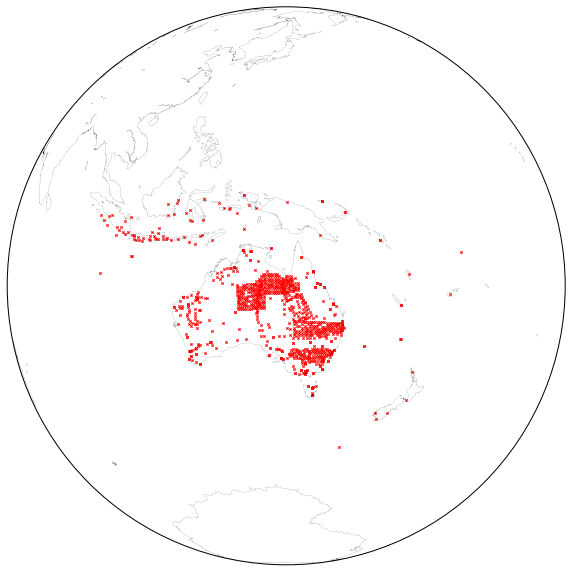

In [8]:
# Select stations within a bounding box and filter by channel name

fig, axes = plt.subplots()

fig.set_size_inches(20,10)
m = Basemap(projection='ortho',lon_0=140,lat_0=-20,resolution='l')
m.drawcoastlines(linewidth=0.1)

print 'Total # of stations: %d'%(len(all_netsta))
lonlat = []
for item in all_netsta:
    net, sta, loc, cha, _, _ = item
    
    lon, lat = fds.unique_coordinates['%s.%s'%(net, sta)]
    #if (lon>90 and lon<180 and lat>-60 and lat<0 and 'S' not in cha and 'E' not in cha and 'Z' in cha):
    if (lon>90 and lon<180 and lat>-60 and lat<0 and 'Z' in cha):
        lonlat.append((net, sta, loc, cha, lon, lat))
    # end if
# end for

lonlat = np.array(lonlat)
print 'Stations selected: %d'%(len(lonlat))
px, py = m(lonlat[:, 4], lonlat[:,5])
m.scatter(px, py, 5, marker='x', color='r')

In [9]:
import fiona
from shapely.geometry import shape,mapping, Point, Polygon, MultiPolygon

In [11]:
# load AU shapefile and filter out stations outside

multipol = fiona.open("au_simple.shp")

au_lonlat = []
for item in lonlat:
    point = Point(float(item[4]), float(item[5]))
    for pol in multipol:
        if point.within(shape(pol['geometry'])):
            au_lonlat.append(item)
        # end if
    # end for
# end for

au_lonlat = np.array(au_lonlat)

Total filtered stations: 971
[u'7B' u'SA01' u'' u'BHZ' u'143.180099' u'-13.9586']
[u'7B' u'SA02' u'' u'BHZ' u'144.484695' u'-17.3633']
[u'7B' u'SA03' u'' u'BHZ' u'142.667801' u'-20.337999']
[u'7B' u'SA04' u'' u'BHZ' u'140.143997' u'-22.941799']
[u'7B' u'SA05' u'' u'BHZ' u'144.272293' u'-23.2005']
[u'7B' u'SA06' u'' u'BHZ' u'148.308594' u'-22.892']
[u'7B' u'SA07' u'' u'BHZ' u'146.781693' u'-26.0327']
[u'7B' u'SA08' u'' u'BHZ' u'150.892593' u'-25.708401']
[u'7B' u'SB01' u'' u'BHZ' u'139.588699' u'-25.792299']
[u'7B' u'SB03' u'' u'BHZ' u'140.264999' u'-28.600201']
[u'7B' u'SB04' u'' u'BHZ' u'145.006104' u'-29.3367']
[u'7B' u'SB05' u'' u'BHZ' u'141.595306' u'-31.878901']
[u'7B' u'SB06' u'' u'BHZ' u'140.146194' u'-35.036659']
[u'7B' u'SB07' u'' u'BHZ' u'144.507706' u'-34.6577']
[u'7B' u'SB08' u'' u'BHZ' u'141.975693' u'-37.4328']
[u'7B' u'SB09' u'' u'BHZ' u'146.857498' u'-32.2892']
[u'7B' u'SB10' u'' u'BHZ' u'149.012497' u'-28.6597']
[u'7B' u'SC01' u'' u'BHZ' u'131.507004' u'-13.4']
[u'7B' 

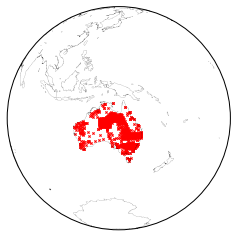

In [14]:
fig.set_size_inches(20,10)
m = Basemap(projection='ortho',lon_0=140,lat_0=-20,resolution='l')
m.drawcoastlines(linewidth=0.1)

print 'Total filtered stations: %d'%(len(au_lonlat))
px, py = m(np.float_(au_lonlat[:, 4]), np.float_(au_lonlat[:, 5]))
m.scatter(px, py, 5, marker='x', color='r')

for item in au_lonlat:
    print item


In [15]:
from scipy.spatial import ckdtree

def rtp2xyz(r, theta, phi):
    xout = np.zeros((r.shape[0], 3))
    rst = r * np.sin(theta)
    xout[:, 0] = rst * np.cos(phi)
    xout[:, 1] = rst * np.sin(phi)
    xout[:, 2] = r * np.cos(theta)
    return xout
# end func

In [17]:
# Filter all stations that are within 'min_dist' km of each other. This gets rid of closely 
# packed stations in dense arrays.

au_lonlat_copy = np.array(au_lonlat)

min_dist=2 #km
while (1):
    
    xyzs = rtp2xyz(6371*np.ones(len(au_lonlat_copy)), np.radians(90-np.float_(au_lonlat_copy[:,5])), 
                   np.radians(np.float_(au_lonlat_copy[:,4])))

    tree = ckdtree.cKDTree(xyzs)    
    
    count=0
    for item in au_lonlat_copy:
        lon, lat = np.float(item[4]), np.float(item[5])
        xyz = rtp2xyz(np.expand_dims(6371, axis=0), 
                      np.expand_dims(np.radians(90-lat), axis=0),
                      np.expand_dims(np.radians(lon), axis=0))
        d, i = tree.query(xyz, k=2, distance_upper_bound=min_dist)

        if(d[0][1]<min_dist): 
            #print d, item, au_lonlat[i[0][1]]
            count+=1            
            au_lonlat_copy = np.delete(au_lonlat_copy, i[0][1], axis=0)
            break
        # end if                
    # end for
    #print count        
    if (count == 0): break
    #break
#wend        

print 'Total number of stations after thinning: %d'%(len(au_lonlat_copy))
for item in au_lonlat_copy:
    print '%s.%s'%(item[0], item[1]) # ', '.join(item)

Total number of stations after thinning: 846
7B.SA01
7B.SA02
7B.SA03
7B.SA04
7B.SA05
7B.SA06
7B.SA07
7B.SA08
7B.SB01
7B.SB03
7B.SB04
7B.SB05
7B.SB06
7B.SB07
7B.SB08
7B.SB09
7B.SB10
7B.SC01
7B.SC02
7B.SC03
7B.SC04
7B.SC05
7B.SC06
7B.SC07
7B.SC08
7B.SC09
7B.SC10
7B.SD01
7B.SD03
7B.SD04
7B.SD05
7B.SD06
7B.SD07
7B.SD08
7B.SD09
7B.SD10
7D.CZ40
7D.CZ41
7D.CZ41A
7D.CZ42
7D.CZ43
7D.CZ44
7D.CZ45
7D.CZ46
7D.DA40
7D.DA41
7D.DA41A
7D.DA42
7D.DA43
7D.DA44
7D.DB40
7D.DB41
7D.DB41A
7D.DB42
7D.DB43
7D.DC40
7D.DC41
7D.DC41A
7D.DC42
7D.DC43
7D.DC44
7D.DD40
7D.DD41
7D.DD41A
7D.DD42
7D.DD43
7D.DE40
7D.DE41
7D.DE41A
7D.DE42
7D.DE43
7D.DE44
7D.DF40
7D.DF41
7D.DF41A
7D.DF42
7D.DF43
7D.DG41
7D.DG41A
7D.DG42
7D.DG43
7D.DG44
7D.KA02
7D.KA03
7D.KA05
7D.KA07
7D.KA08
7D.KA09
7D.KA10
7E.KB03
7E.KB04
7E.KB06
7E.KB07
7E.KB08
7E.KB10
7F.CR40
7F.CR41
7F.CR42
7F.CR43
7F.CR44
7F.CR45
7F.CR46
7F.CS40
7F.CS41
7F.CS42
7F.CS43
7F.CS44
7F.CS45
7F.CT40
7F.CT41
7F.CT42
7F.CT43
7F.CT44
7F.CT46
7F.CU41
7F.CV40
7F.CV41
7F.CV42
7F.

846


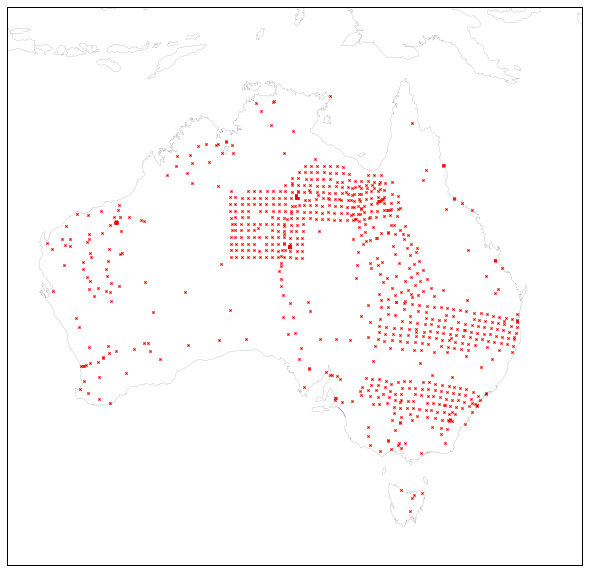

In [18]:
fig, axes = plt.subplots()

fig.set_size_inches(20,10)
m = Basemap(ax=axes, llcrnrlon=105,llcrnrlat=-45,urcrnrlon=155,urcrnrlat=-5,
            resolution='l',projection='tmerc',lon_0=130,lat_0=-25)
m.drawcoastlines(linewidth=0.1)

print len(au_lonlat_copy)
px, py = m(np.float_(au_lonlat_copy[:, 4]), np.float_(au_lonlat_copy[:, 5]))
m.scatter(px, py, 5, marker='x', color='r')

plt.savefig('/tmp/stations_all.pdf')